In [3]:
import os
import matplotlib.pyplot as plt
import re
import json
import pandas as pd
from datasets import ChineseDataset
from transformers import AutoTokenizer
from label_mappings import *
from collections import Counter
%matplotlib inline
# loss_pattern = re.compile(r"Loss (.*?), NER Loss (.*?), Target Aspect Loss (.*?), Target Sentiment Loss (.*?)$")
# acc_pattern = re.compile(r"Ner Acc (.*?), Target Aspect Acc (.*?), Target Sentiment Acc (.*?)$")
loss_pattern = re.compile(r"Loss (.*?), \('Ner Loss', (.*?)\),  \('CLS Classification Loss',(.*?)\)")
acc_pattern = re.compile(r"\('Ner Acc', (.*?)\), \('CLS Classification Acc', (.*?)\)$")
train_acc_pattern = re.compile(r"\('Ner Acc', (.*?)\),  \('CLS Classification Acc', (.*?)\)")

In [4]:
file_path = 'data/semeval2016/phone_chinese/手机标注_new.xlsx'
tokenizer = AutoTokenizer.from_pretrained('bert-base-chinese', cache_dir='/lzl/models/bert-base-chinese')
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
dataset = ChineseDataset(file_path, tokenizer, sentence_b=ASPECT_SENTENCE, model_type="end_to_end")

/usr/local/lib/python3.8/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [84]:
df = pd.read_excel(file_path)

map_dict = {
    "屏幕、显示": [["DISPLAY"], []],
    "电池、电源、充电、续航、待机": [["BATTERY", "POWER_SUPPLY"], []],
    "操作系统、处理器、内存、性能": [["MEMORY", "OS", "CPU"], ["OPERATION_PERFORMANCE"]],
    "硬件、设备、存储、零件、容量": [["HARD_DISC", "HARDWARE"], []],
    "软件、程序、游戏、应用": [["SOFTWARE"], []],
    "键盘、按键、按钮、输入": [["KEYBOARD"], []],
    "网络、信号、传输、接口、通话、蓝牙": [["PORTS"], ["CONNECTIVITY"]],
    "多媒体、视频、音乐、拍照、摄影": [["MULTIMEDIA_DEVICES"], []],
    "销售、售后、服务支持": [["SUPPORT"], []],
    "售价、价格":[[], ["PRICE"]],
    "手机综合、整体":[["PHONE"], []]
}

general_map = {
    "屏幕、显示": "显示",
    "电池、电源、充电、续航、待机": "电源",
    "操作系统、处理器、内存、性能": "系统性能",
    "硬件、设备、存储、零件、容量": "硬件设备",
    "软件、程序、游戏、应用": "软件应用",
    "键盘、按键、按钮、输入": "键盘输入",
    "网络、信号、传输、接口、通话、蓝牙": "移动通信",
    "多媒体、视频、音乐、拍照、摄影": "多媒体",
    "销售、售后、服务支持": "服务支持",
    "售价、价格": "价格",
    "手机综合、整体": "综合"
}

In [85]:
rev_map_1 = {}
rev_map_2 = {}
for new_asp, origin_asp in map_dict.items():
    first, second = origin_asp
    for item in first:
        rev_map_1[item] = new_asp
    for item in second:
        rev_map_2[item] = new_asp
    
def change_aspect(origin_asp):
    if pd.isna(origin_asp):
        return origin_asp
    first, second = origin_asp.split("#")
    if second in rev_map_2:
        new_asp = rev_map_2[second]
    else:
        new_asp = rev_map_1[first]
    return general_map[new_asp]

def replace_target(target):
    if pd.isna(target):
        return target
    else:
        if target.lower() == "none":
#             print(target)
            new = "NULL"
            return new
        else:
            return target

def get_from_to(df):
    start_result = []
    end_result = []
    for idx, row in df.iterrows():
        text = row['text']
        target = row['target']
        if pd.notna(target):
            if target != "NULL":
                try:
                    start = text.index(target)
                    end = start + len(target)
                except ValueError:
                    print(idx, row)
                    start, end = None, None
                start_result.append(str(start))
                end_result.append(str(end))
            else:
                start_result.append("0")
                end_result.append("0")
        else:
            start_result.append(None)
            end_result.append(None)
    df['from'] = start_result
    df['to'] = end_result
    return df

def replace_polarity(p):
    if pd.isna(p):
        return p
    elif p == "negative":
        new = "负面"
    elif p == "neutral":
        new = "中性"
    elif p == "positive":
        new = "正面"
    else:
        raise ValueError(p)
    return new
        
            
        
df['category'] = df['category'].apply(change_aspect)
df['target'] = df['target'].apply(replace_target)
df['polarity'] = df['polarity'].apply(replace_polarity)
df = get_from_to(df)

In [86]:
df.to_csv("./data/semeval2016/phone_chinese/labeled_phone.csv", index=False)

In [87]:
new = df[~df['category'].isna()].copy()
new[new['target'].isna()]

,text,target,category,polarity,from,to


1

In [24]:
df = pd.read_excel(file_path)
df = df.dropna(axis=0, subset="category")
set([each.split("#")[1] for each in df['category'].values])
df[df["category"].str.contains("PRICE")]

,text,target,category,polarity
558,性价比非常高，非常超值，,性价比,PHONE#PRICE,positive
736,首先不得不说这是一款性价比非常不错的低端智能机。,性价比,PHONE#PRICE,positive
1198,价格跌的较快。,价格,PHONE#PRICE,negative
2447,2、价格还是可以，,价格,PHONE#PRICE,positive
2532,整体感觉性价比不错；,性价比,PHONE#PRICE,positive
2800,这样的性价比还算不错了。,性价比,PHONE#PRICE,positive
3974,买安卓机能有这样的效果还这价位一个行货也够值了，,价位,PHONE#PRICE,positive
3975,买安卓机能有这样的效果还这价位一个行货也够值了，,NaN,PHONE#PRICE,positive
4159,很多人说x903 价格偏高，,价格,PHONE#PRICE,negative
4356,性价比还可以，,性价比,PHONE#PRICE,positive


In [3]:
init_dir = '/lzl/models/bert-base-cased'
init_model = 'bert-base-cased'
test_path = "./data/semeval2016/EN_REST_SB1_TEST_LABELED.xml"
train_path = "./data/semeval2016/ABSA16_Restaurants_Train_SB1_v2.xml"
tokenizer = AutoTokenizer.from_pretrained(init_model, cache_dir=init_dir)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
test_dataset = SemEvalDataSet(test_path, tokenizer, SENTENCE_B)
train_dataset  = SemEvalDataSet(train_path, tokenizer, SENTENCE_B)



In [4]:
sentences = []
targets = []
categorys = []
polaritys = []
for sent, jobjs in train_dataset.string_sentences:
    jobjs = json.loads(jobjs)
    sentences.append(sent)
    for jobj in jobjs:
        targets.append(jobj["target"])
        categorys.append(jobj["category"])
        polaritys.append(jobj["polarity"])

In [17]:
101 / len(polaritys)

0.04028719585161548

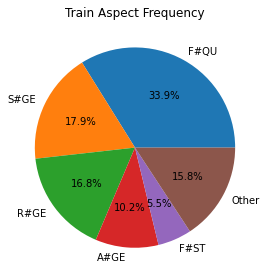

In [14]:
c = Counter(categorys)
top_10 = c.most_common(5)

labels = [each[0][0] + "#" + each[0].split("#")[1][:2] for each in top_10] + ["Other"]
values = [each[1] for each in top_10]
values = values + [len(categorys) - sum(values)]

plt.pie(values, labels=labels, autopct='%1.1f%%')
plt.title("Train Aspect Frequency")
# plt.legend()
# res = plt.bar([each[0] for each in top_10], [each[1] for each in top_10])
# plt.title("Train polaritys Frequency")
# plt.xlabel("Polaritys")
# plt.ylabel("Frequency")
# plt.bar_label(res, label_type='edge')
# # plt.xticks(rotation=90)
# plt.tight_layout()
plt.tight_layout()
plt.savefig("./plots/pie_aspect.png", dpi=300)
plt.show()

In [40]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
with open('./logs/v2_e2e_30_2_layer_pool_256_h_aug23.log') as f:
    for line in f:
        line = line.strip()
        if "train.py:  146" in line:
            train_loss_list.append([float(each) for each in re.findall(loss_pattern, line)[0]])
        elif "train.py:  156" in line:
            train_acc_list.append([float(each) for each in re.findall(train_acc_pattern, line)[0]])
        elif "train.py:  175" in line:
            test_loss_list.append([float(each) for each in re.findall(loss_pattern, line)[0]])
        elif "train.py:  176" in line:
            test_acc_list.append([float(each) for each in re.findall(acc_pattern, line)[0]])

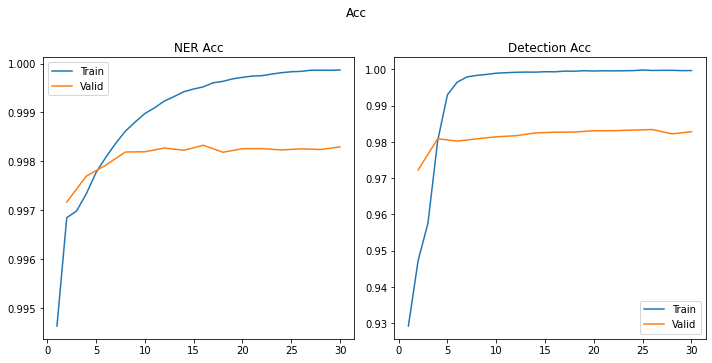

In [51]:
names = ["NER Acc", "Detection Acc"]
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,5))
fig.suptitle("Acc", y=1)
for i in range(2):
        train_datas = [each[i] for each in train_acc_list]
        test_datas = [each[i] for each in test_acc_list]
        axes[i].plot(range(1, len(train_datas) + 1), train_datas, label="Train")
        axes[i].plot(range(2, len(train_datas) + 1, 2), test_datas, label="Valid")
        axes[i].set_title(names[i])
        axes[i].legend()
plt.tight_layout()
plt.savefig("./plots/end_to_end_acc.png", dpi=300)
plt.show()

In [38]:
acc_pattern

re.compile(r"\('Ner Acc', (.*?)\), \('CLS Classification Acc', (.*?)\)$",
re.UNICODE)

In [2]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
with open('./logs/train_256_dropout.log') as f:
    for line in f:
        line = line.strip()
        if "train.py:   92" in line:
            train_loss_list.append([float(each) for each in re.findall(loss_pattern, line)[0]])
        elif "train.py:   98" in line:
            train_acc_list.append([float(each) for each in re.findall(acc_pattern, line)[0]])
        elif "train.py:  112" in line:
            test_loss_list.append([float(each) for each in re.findall(loss_pattern, line)[0]])
        elif "train.py:  113" in line:
            test_acc_list.append([float(each) for each in re.findall(acc_pattern, line)[0]])

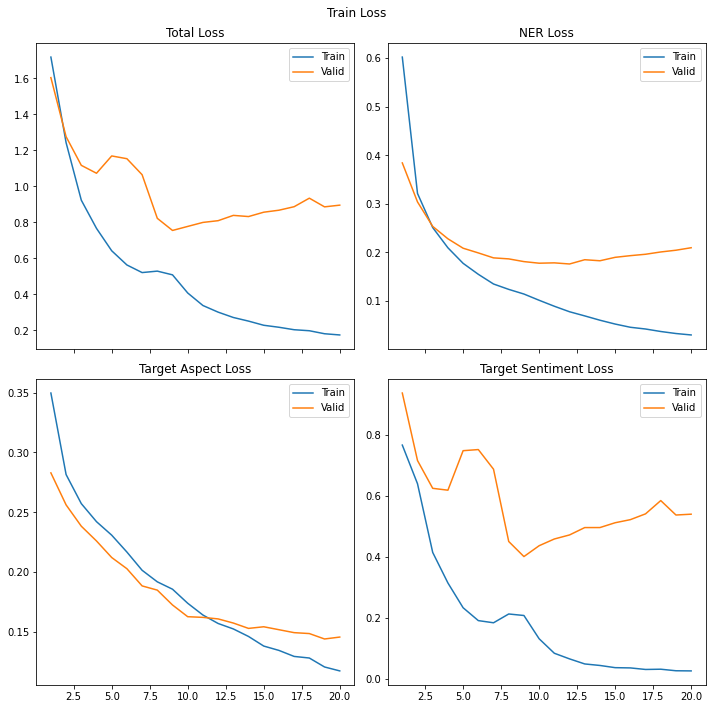

In [15]:
names = ["Total Loss", "NER Loss", "Target Aspect Loss", "Target Sentiment Loss"]
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(10, 10))
fig.suptitle("Train Loss")
for i in range(2):
    for j in range(2):
        train_datas = [each[i * 2 + j] for each in train_loss_list]
        test_datas = [each[i * 2 + j] for each in test_loss_list]
        axes[i, j].plot(range(1, len(train_datas) + 1), train_datas, label="Train")
        axes[i, j].plot(range(1, len(test_datas) + 1), test_datas, label="Valid")
        axes[i, j].set_title(names[i * 2 + j])
        axes[i, j].legend()
plt.tight_layout()
plt.savefig("./plots/loss.png", dpi=300)
plt.show()


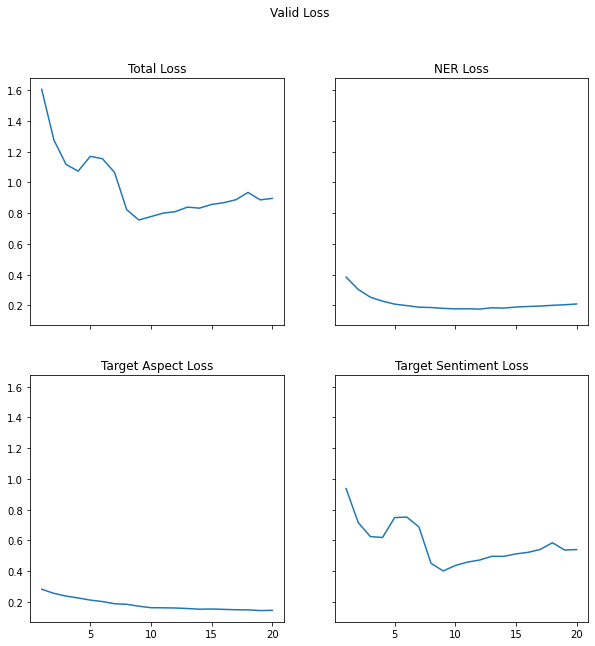

In [61]:
# names = ["Total Loss", "NER Loss", "Target Aspect Loss", "Target Sentiment Loss"]
# fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))
# fig.suptitle("Valid Loss")
# for i in range(2):
#     for j in range(2):
#         datas = [each[i * 2 + j] for each in test_loss_list]
#         axes[i, j].plot(range(1, len(datas) + 1), datas)
#         axes[i, j].set_title(names[i * 2 + j])
# plt.savefig("./plots/valid_loss.png", dpi=300)
# plt.show()

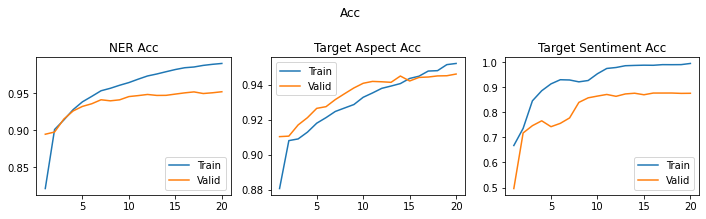

In [17]:
names = ["NER Acc", "Target Aspect Acc", "Target Sentiment Acc"]
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, figsize=(10,3))
fig.suptitle("Acc", y=1)
for i in range(3):
        train_datas = [each[i] for each in train_acc_list]
        test_datas = [each[i] for each in test_acc_list]
        axes[i].plot(range(1, len(train_datas) + 1), train_datas, label="Train")
        axes[i].plot(range(1, len(test_datas) + 1), test_datas, label="Valid")
        axes[i].set_title(names[i])
        axes[i].legend()
plt.tight_layout()
plt.savefig("./plots/acc.png", dpi=300)
plt.show()

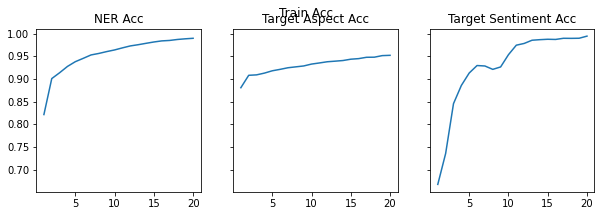

In [70]:
names = ["NER Acc", "Target Aspect Acc", "Target Sentiment Acc"]
fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(10,3))
fig.suptitle("Train Acc")
for i in range(3):
        datas = [each[i] for each in train_acc_list]
        axes[i].plot(range(1, len(datas) + 1), datas)
        axes[i].set_title(names[i])
plt.savefig("./plots/train_acc.png", dpi=300)
plt.show()